In [13]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import matplotlib.dates as mdates
import codecs
import scipy.signal
import pprint

In [3]:
from collections import defaultdict

In [4]:
orig_json = None
with codecs.open('D:\\Research\\pooya.json',encoding='utf-8') as f:
    orig_json = json.loads(f.read())

In [5]:
lifeLog = orig_json['lifeLog']

In [19]:
#print(lifeLog['0117_2018']['mobile'].keys())
#sample = ['0116_2018', '0117_2018', '1214_2017']
#json_sample = {key:value for key,value in lifeLog.items() if key in sample}
#json_sample = {key:value for key,value in lifeLog.items()}
activities_list = []

for i in list(lifeLog.keys())[70:72]:
    if type(lifeLog[i]['mobile']) == list:
        activities_list += [j for j in lifeLog[i]['mobile'] if j]
    else:
        activities_list += [j for j in lifeLog[i]['mobile'].values()]
#print(json.dumps(json_sample))
#with open('json_sample','w+') as f:
#    f.write(json.dumps(json_sample))

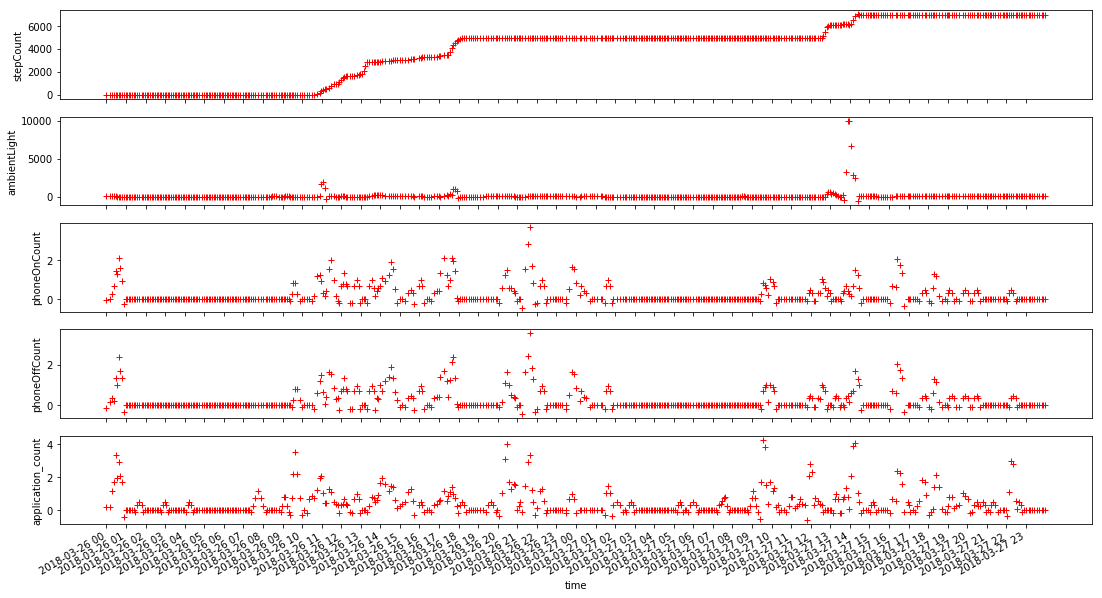

In [47]:
activities_list.sort(key=lambda x: x['time']['timeStamp'])
ys = ['stepCount','ambientLight','phoneOnCount','phoneOffCount']
fig, axarr = plt.subplots(len(ys)+1, sharex=True)
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('time')
x_data = [datetime.datetime.fromtimestamp(i['time']['timeStamp']/1000) for i in activities_list]
dt64 = [np.datetime64(dt) for dt in x_data]
plt.xticks([i.tolist() for i in np.arange(min(dt64), max(dt64)+1,datetime.timedelta(days=3))])

for index,i in enumerate(ys):
    y_data = np.array([j[i] for j in activities_list])
    #y_data = scipy.signal.savgol_filter(np_arr, 5, 2)
    y_data = scipy.signal.savgol_filter(y_data, 5, 2)
    axarr[index].set_ylabel(i)
    axarr[index].plot(x_data,y_data,'r+')
y_data = np.array([j['application']['count'] for j in activities_list])
# y_data = scipy.signal.savgol_filter(y_data, 5, 3)
axarr[index+1].set_ylabel('application_count')


axarr[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
axarr[0].xaxis.set_ticks([i.tolist() for i in np.arange(min(dt64), max(dt64)+1,datetime.timedelta(hours=1))])

axarr[index+1].plot(x_data,y_data,'r+')
plt.show()

In [36]:
orig_json['lifeLog']['0315_2018']['wearable']['daily']['sleep']

[{'asleep': 0,
  'awake': 0,
  'deep': 77,
  'efficiency': 94,
  'endTime': '2018-03-15T08:13:30.000',
  'endTimeWindow': '20180315_99',
  'light': 249,
  'minutesAsSleep': 404,
  'rem': 78,
  'restless': 0,
  'startTime': '2018-03-15T00:51:30.000',
  'startTimeWindow': '20180315_11',
  'wake': 38}]

In [ ]:
#constants for how important each feature is
AMBIENT_LIGHT = 0.1
STEP_COUNT = 0.3
APP = 0.2
merged = []
prev_steps = 0
prev_light = 0
#prev_app_num = 0;
for i in list(lifeLog.values()):
    for j in i['mobile']:
        if j == None:
            continue
        if type(j) == str:
            x = {
                'time': datetime.datetime(int(i['mobile'][j]['time']['dateFormat'][:4]),
                                          int(i['mobile'][j]['time']['dateFormat'][4:6]),
                                          int(i['mobile'][j]['time']['dateFormat'][6:8]),
                                          hour=int(i['mobile'][j]['time']['dateFormat'][9:11]),
                                          minute=int(i['mobile'][j]['time']['dateFormat'][12:14])),
                'timeWindow': i['mobile'][j]['time']['timeWindow']
            }
            x['chance'] = 0.7
            x['chance'] -= (i['mobile'][j]['stepCount'] - prev_steps) * STEP_COUNT
            x['chance'] += min(abs(x['time'].hour - 20),abs(8-x['time'].hour)) * 1/6 * 1/4 
            if (i['mobile'][j]['ambientLight'] - prev_light) * AMBIENT_LIGHT < -0.3:
                x['chance'] += .3
            else:
                x['chance'] -= (i['mobile'][j]['ambientLight'] - prev_light) * AMBIENT_LIGHT
            
            if 'application' in i['mobile'][j]:
                x['chance'] -= (i['mobile'][j]['application']['count']) * APP
            else:
                print('wtaf')
                
            if x['chance'] < 0:
                x['chance']  = 0
            prev_light = i['mobile'][j]['ambientLight']
            prev_steps = i['mobile'][j]['stepCount']
            merged.append(x)
        else:
            x = {
                'time': datetime.datetime(int(j['time']['dateFormat'][:4]),
                                          int(j['time']['dateFormat'][4:6]),
                                          int(j['time']['dateFormat'][6:8]),
                                          hour=int(j['time']['dateFormat'][9:11]),
                                          minute=int(j['time']['dateFormat'][12:14])),
                'timeWindow': j['time']['timeWindow']
            }
            x['chance'] = 0.7
            x['chance'] -= (j['stepCount'] - prev_steps) * STEP_COUNT

            
            x['chance'] += min(abs(x['time'].hour - 20),abs(8-x['time'].hour)) * 1/6 * 1/4 
            if (j['ambientLight'] - prev_light) * AMBIENT_LIGHT < -0.3:
                x['chance'] += .3
            else:
                x['chance'] -= (j['ambientLight'] - prev_light) * AMBIENT_LIGHT
            
#             if  (j['application']['count']) * APP < x['chance']-1:
#                 x['chance'] += .2
#             else:
#                 x['chance'] -= (j['application']['count']) * APP
            x['chance'] -= (j['application']['count']) * APP

            if x['chance'] < 0:
                x['chance']  = 0
            prev_light = j['ambientLight']
            prev_steps = j['stepCount']
            #prev_app_num = j['application']['count']
            merged.append(x)
        
#pprint.pprint([x['chance'] for x in merged])
    


In [ ]:
pprint.pprint([x['chance'] for x in merged])

In [ ]:
sleep_history = []
buffer = []
start = 0
for i in merged:
    if i['chance'] > 0.6 and start == 0:
        start = i
    elif start != 0:
        if len(buffer) == 10:
            del buffer[0]
        buffer.append(i)
        count = 0
        for time in buffer:
            if time['chance'] < 0.4:
                count +=1

        if count > 1:
            # minutes asleep > 4 hrs
            b = sorted(buffer,key=lambda x:x['chance'])[-1]
            if (b['time'] - start['time']).total_seconds()/60 > 240:
                sleep_history.append({
                    'startTimeWindow':start['timeWindow'],
                    'endTimeWindow': b['timeWindow'],
                    'startTime': start['time'],
                    'endTime': b['time'],
                    'minutesAsSleep': (b['time'] - start['time']).total_seconds()/60
                })
            buffer = []
            start = 0





In [ ]:
pprint.pprint([i['startTime'] for i in sleep_history])

In [ ]:
x = []
for i in orig_json['lifeLog'].values():
    try:
        end_time =  datetime.datetime(int(i['wearable']['daily']['sleep'][0]['endTime'][:4]),
                                      int(i['wearable']['daily']['sleep'][0]['endTime'][5:7]),
                                      int(i['wearable']['daily']['sleep'][0]['endTime'][8:10]),
                                      hour=int(i['wearable']['daily']['sleep'][0]['endTime'][11:13]),
                                      minute=int(i['wearable']['daily']['sleep'][0]['endTime'][14:16]))
        start_time =  datetime.datetime(int(i['wearable']['daily']['sleep'][0]['startTime'][:4]),
                                      int(i['wearable']['daily']['sleep'][0]['startTime'][5:7]),
                                      int(i['wearable']['daily']['sleep'][0]['startTime'][8:10]),
                                      hour=int(i['wearable']['daily']['sleep'][0]['startTime'][11:13]),
                                      minute=int(i['wearable']['daily']['sleep'][0]['startTime'][14:16]))
        
        start_dif_info = min([(abs(start_time-j['startTime']),(start_time-j['startTime']),ind) for ind,j in enumerate(sleep_history)])
        end_dif_info = min([(abs(end_time-j['endTime']),(end_time-j['endTime']),ind) for ind,j in enumerate(sleep_history)])
        differences = {
            "startTimeDifference": start_dif_info[1].total_seconds()/60,
            "endTimeDifference": end_dif_info[1].total_seconds()/60,
            "fitBitStart": start_time,
            "windowStart": sleep_history[end_dif_info[2]]['startTime'],
            "fitBitEnd": end_time,
            "windowEnd": sleep_history[end_dif_info[2]]['endTime']
        }
        
        x.append(differences)
    except KeyError as e:
        print(e)
        pass
pprint.pprint(x)

In [ ]:
start_average = [abs(i['startTimeDifference']) for i in x if abs(i['startTimeDifference']) < 288]
print("Average absolute value of start time error (m) excluding impossible numbers from missing data:",sum(start_average)/len(start_average))
end_average = [abs(i['endTimeDifference']) for i in x if abs(i['endTimeDifference']) < 288]
print("Average absolute value of end time error (m) excluding impossible numbers from missing data:",sum(end_average)/len(end_average))
duration_average = [abs((i['windowEnd'] - i['windowStart']) - (i['fitBitEnd'] - i['fitBitStart'])).total_seconds()/60 for i in x if abs(i['endTimeDifference']) < 288]
print("Average absolute value of duration error (m) excluding impossible numbers from missing data:",sum(duration_average)/len(duration_average))


In [ ]:
times_start = []
times_end = []
for i in lifeLog:
    if 'wearable' in lifeLog[i]:
        for j in lifeLog[i]['wearable']['daily']['sleep']:
            times_start.append(j['startTimeWindow'])
            times_end.append(j['endTimeWindow'])
    

In [ ]:
for i in times_start[1:]:
    index_string = i[4:8]+'_'+i[0:4]
    apps = []
    for j in range(-5,5):
        if lifeLog[index_string]['mobile'][int(i[-1])+j] != None:
            if lifeLog[index_string]['mobile'][int(i[-1])+j]['application']['count'] != 0:
                apps.extend(lifeLog[index_string]['mobile'][int(i[-1])+j]['application']['labeledApp'])
            #else:
            #    apps.append(0)
    #print(apps)
print('apps at ending time')
for i in times_end[1:]:
    index_string = i[4:8]+'_'+i[0:4]
    apps = []
    for j in range(-10,10):
        if lifeLog[index_string]['mobile'][int(i[9:])+j] != None:
            if lifeLog[index_string]['mobile'][int(i[9:])+j]['application']['count'] != 0:
                apps.extend(lifeLog[index_string]['mobile'][int(i[9:])+j]['application']['labeledApp'])
            #else:
            #   apps.append(0)
    print(i,'Clock' in [i['name'] for i in apps])
    #print(apps)

In [ ]:
print(lifeLog['0315_2018']['mobile'][0])
